In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
df = pd.read_csv('/content/Amazon Sale Report.csv', encoding='latin1')


In [5]:
df.head()       # Shows first 5 rows
df.info()       # Shows data types and non-null values
df.columns      # Lists all column names


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128976 entries, 0 to 128975
Data columns (total 21 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   index               128976 non-null  int64  
 1   Order ID            128976 non-null  object 
 2   Date                128976 non-null  object 
 3   Status              128976 non-null  object 
 4   Fulfilment          128976 non-null  object 
 5   Sales Channel       128976 non-null  object 
 6   ship-service-level  128976 non-null  object 
 7   Category            128976 non-null  object 
 8   Size                128976 non-null  object 
 9   Courier Status      128976 non-null  object 
 10  Qty                 128976 non-null  int64  
 11  currency            121176 non-null  object 
 12  Amount              121176 non-null  float64
 13  ship-city           128941 non-null  object 
 14  ship-state          128941 non-null  object 
 15  ship-postal-code    128941 non-nul

Index(['index', 'Order ID', 'Date', 'Status', 'Fulfilment', 'Sales Channel',
       'ship-service-level', 'Category', 'Size', 'Courier Status', 'Qty',
       'currency', 'Amount', 'ship-city', 'ship-state', 'ship-postal-code',
       'ship-country', 'B2B', 'fulfilled-by', 'New', 'PendingS'],
      dtype='object')

In [6]:
print(df.columns)

Index(['index', 'Order ID', 'Date', 'Status', 'Fulfilment', 'Sales Channel',
       'ship-service-level', 'Category', 'Size', 'Courier Status', 'Qty',
       'currency', 'Amount', 'ship-city', 'ship-state', 'ship-postal-code',
       'ship-country', 'B2B', 'fulfilled-by', 'New', 'PendingS'],
      dtype='object')


In [7]:
df['Order Date'] = pd.to_datetime(df['Date'], errors='coerce')


/tmp/ipython-input-7-1206951904.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Order Date'] = pd.to_datetime(df['Date'], errors='coerce')


In [8]:
df = df.dropna(subset=['Order Date'])


In [9]:
# Trim stray spaces in headers, just in case
df.columns = df.columns.str.strip()

# Pick whichever name actually exists
DATE_COL = None
for candidate in ['Order Date', 'Date', 'order_date', 'date']:
    if candidate in df.columns:
        DATE_COL = candidate
        break

assert DATE_COL, "Could not find a date column ― check df.columns()"
print(f"Using date column: {DATE_COL}")


Using date column: Order Date


In [10]:
df[DATE_COL].head(10).tolist()


[Timestamp('2022-04-30 00:00:00'),
 Timestamp('2022-04-30 00:00:00'),
 Timestamp('2022-04-30 00:00:00'),
 Timestamp('2022-04-30 00:00:00'),
 Timestamp('2022-04-30 00:00:00'),
 Timestamp('2022-04-30 00:00:00'),
 Timestamp('2022-04-30 00:00:00'),
 Timestamp('2022-04-30 00:00:00'),
 Timestamp('2022-04-30 00:00:00'),
 Timestamp('2022-04-30 00:00:00')]

In [11]:
df[DATE_COL] = pd.to_datetime(df[DATE_COL],
                              format='%d/%m/%Y',   # <-- adjust if needed
                              errors='coerce')


In [12]:
df[DATE_COL] = pd.to_datetime(df[DATE_COL],
                              dayfirst=True,       # dd/mm/yyyy & dd-mm-yyyy
                              errors='coerce')


In [13]:
df = df.dropna(subset=[DATE_COL])


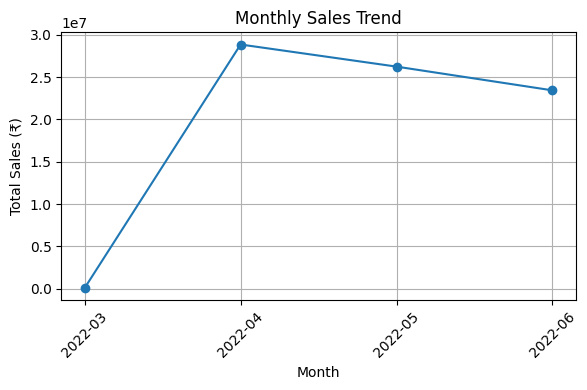

In [14]:
# Make a period (YYYY‑MM) column
df['Order Month'] = df[DATE_COL].dt.to_period('M')

# Ensure Amount is numeric
df['Amount'] = pd.to_numeric(df['Amount'], errors='coerce')
df = df.dropna(subset=['Amount'])

# Aggregate monthly sales
monthly_sales = (df
                 .groupby('Order Month')['Amount']
                 .sum()
                 .reset_index())

# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.plot(monthly_sales['Order Month'].astype(str),
         monthly_sales['Amount'],
         marker='o')
plt.title('Monthly Sales Trend')
plt.xlabel('Month')
plt.ylabel('Total Sales (₹)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [15]:
# Strip spaces & unneeded symbols
df['Category'] = df['Category'].str.strip()
df['Product Size'] = df['Size'].astype(str).str.strip()
df['Qty']   = pd.to_numeric(df['Qty'], errors='coerce')
df = df.dropna(subset=['Qty'])


In [16]:
top_cat_rev = (df
               .groupby('Category')['Amount']
               .sum()
               .sort_values(ascending=False)
               .head(10))
print(top_cat_rev)


Category
T-shirt     39206756.65
Shirt       21297770.08
Blazzer     11215104.12
Trousers     5346286.30
Perfume       789419.66
Wallet        458408.18
Socks         150757.50
Shoes         124752.76
Watch            915.00
Name: Amount, dtype: float64


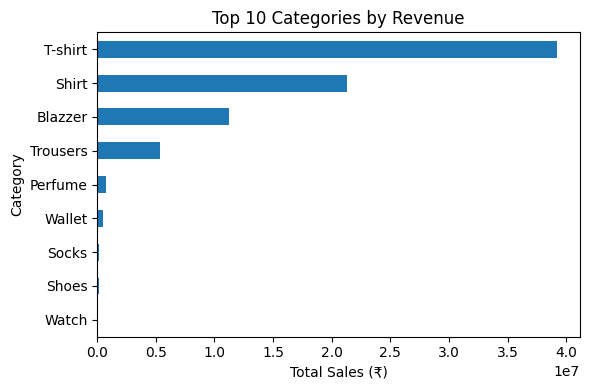

In [17]:
top_cat_rev.plot(kind='barh', figsize=(6,4))
plt.title('Top 10 Categories by Revenue')
plt.xlabel('Total Sales (₹)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


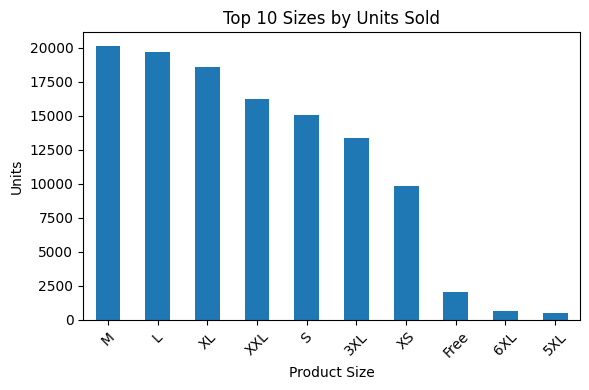

In [18]:
top_sizes_qty = (df
                 .groupby('Product Size')['Qty']
                 .sum()
                 .sort_values(ascending=False)
                 .head(10))

top_sizes_qty.plot(kind='bar', figsize=(6,4))
plt.title('Top 10 Sizes by Units Sold')
plt.ylabel('Units')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


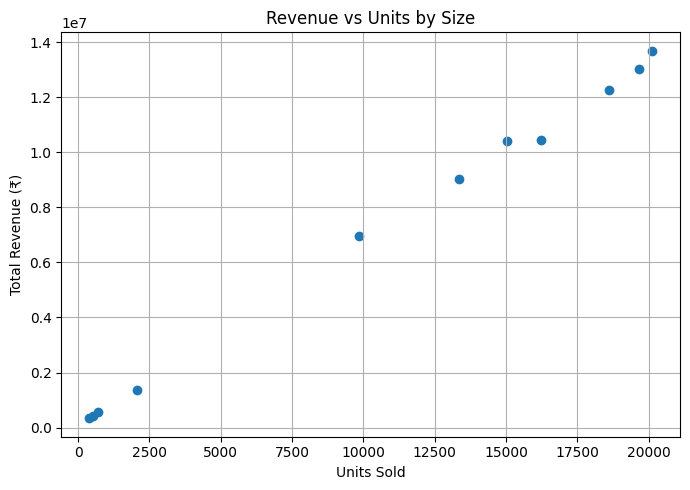

In [19]:
size_rev_vs_qty = (df
                   .groupby('Product Size')
                   .agg(units=('Qty','sum'),
                        revenue=('Amount','sum'))
                   .reset_index())

# Scatter to spot under‑/over‑priced sizes
plt.figure(figsize=(7,5))
plt.scatter(size_rev_vs_qty['units'], size_rev_vs_qty['revenue'])
plt.title('Revenue vs Units by Size')
plt.xlabel('Units Sold')
plt.ylabel('Total Revenue (₹)')
plt.grid(True)
plt.tight_layout()
plt.show()


In [20]:
print(top_cat_rev)

Category
T-shirt     39206756.65
Shirt       21297770.08
Blazzer     11215104.12
Trousers     5346286.30
Perfume       789419.66
Wallet        458408.18
Socks         150757.50
Shoes         124752.76
Watch            915.00
Name: Amount, dtype: float64


In [ ]:
df['Fulfilment'].unique()


array(['Merchant', 'Amazon'], dtype=object)

In [21]:
# --- Clean fulfilment labels (remove trailing spaces) ---
df['Fulfilment'] = df['Fulfilment'].astype(str).str.strip()

# --- Basic volume & revenue by fulfilment ---
ful_metrics = (df
               .groupby('Fulfilment')
               .agg(orders=('Order ID', 'nunique'),
                    revenue=('Amount', 'sum'))
               .reset_index())

ful_metrics['AOV'] = ful_metrics['revenue'] / ful_metrics['orders']
print(ful_metrics)


  Fulfilment  orders      revenue         AOV
0     Amazon   78211  54327540.00  694.627866
1   Merchant   34676  24262630.25  699.695185


In [22]:
# Create a boolean: True if cancelled / returned
cancel_mask = df['Status'].isin(['Cancelled', 'Returned'])
df['is_cancel'] = cancel_mask

ful_cxl = (df
           .groupby('Fulfilment')['is_cancel']
           .mean()
           .reset_index()
           .rename(columns={'is_cancel': 'cancel_rate'}))

ful_metrics = ful_metrics.merge(ful_cxl, on='Fulfilment', how='left')


In [23]:
if {'Ship Date', 'Order Date'}.issubset(df.columns):
    df['Ship Date'] = pd.to_datetime(df['Ship Date'], errors='coerce')
    df['ship_days'] = (df['Ship Date'] - df['Order Date']).dt.days
    ful_ship = (df
                .groupby('Fulfillment')['ship_days']
                .median()
                .reset_index())
    ful_metrics = ful_metrics.merge(ful_ship, on='Fulfillment', how='left')


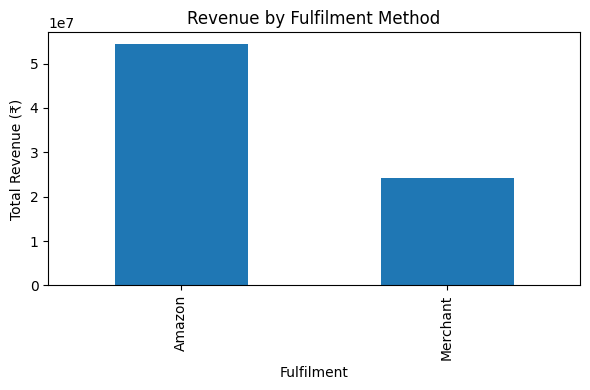

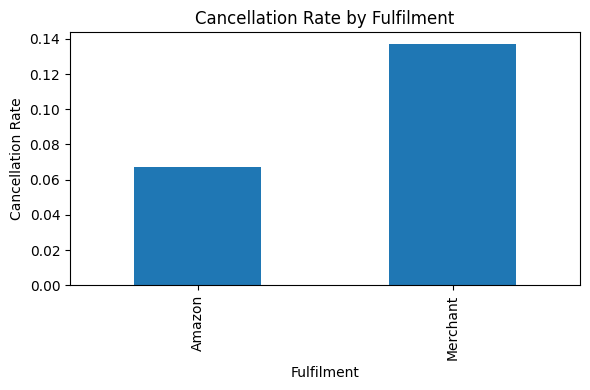

In [24]:
# Revenue share
ful_metrics.plot(kind='bar', x='Fulfilment', y='revenue', legend=False,
                 ylabel='Total Revenue (₹)', title='Revenue by Fulfilment Method',
                 figsize=(6,4)); plt.tight_layout(); plt.show()

# Optional: cancellation rate
if 'cancel_rate' in ful_metrics.columns:
    ful_metrics.plot(kind='bar', x='Fulfilment', y='cancel_rate', legend=False,
                     ylabel='Cancellation Rate', title='Cancellation Rate by Fulfilment',
                     figsize=(6,4)); plt.tight_layout(); plt.show()


In [25]:
print(ful_metrics)

  Fulfilment  orders      revenue         AOV  cancel_rate
0     Amazon   78211  54327540.00  694.627866     0.067293
1   Merchant   34676  24262630.25  699.695185     0.136808


In [26]:
print(df.columns.tolist())
# Common options →
# 'Ship City', 'Shipping City', 'City', 'Ship-State', 'State', 'Customer ID' …


['index', 'Order ID', 'Date', 'Status', 'Fulfilment', 'Sales Channel', 'ship-service-level', 'Category', 'Size', 'Courier Status', 'Qty', 'currency', 'Amount', 'ship-city', 'ship-state', 'ship-postal-code', 'ship-country', 'B2B', 'fulfilled-by', 'New', 'PendingS', 'Order Date', 'Order Month', 'Product Size', 'is_cancel']


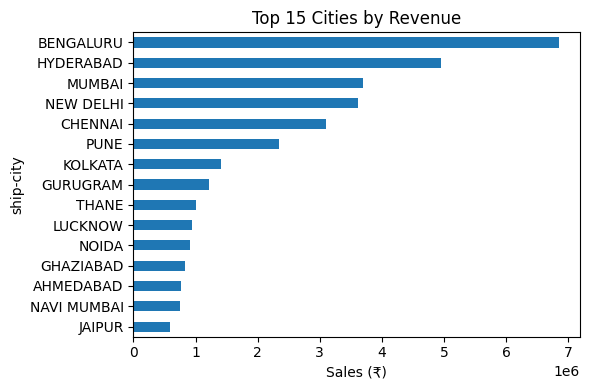

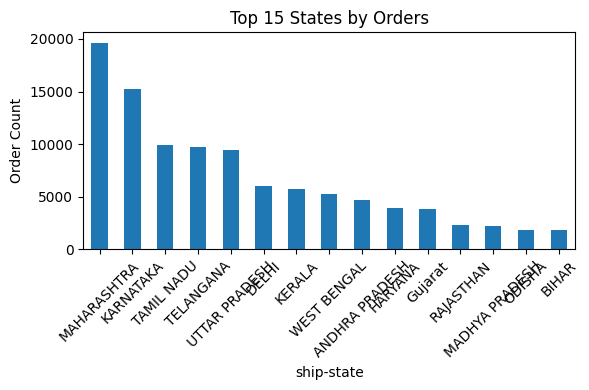

In [27]:
CITY_COL   = 'ship-city'   # adjust
STATE_COL  = 'ship-state'  # adjust
CUST_COL   = 'Customer ID' # adjust

# --- Revenue by city ---
top_city_rev = (df
                .groupby(CITY_COL)['Amount']
                .sum()
                .sort_values(ascending=False)
                .head(15))
top_city_rev.plot(kind='barh', figsize=(6,4))
plt.title('Top 15 Cities by Revenue')
plt.xlabel('Sales (₹)')
plt.gca().invert_yaxis()
plt.tight_layout(); plt.show()

# --- Orders by state ---
top_state_ord = (df
                 .groupby(STATE_COL)['Order ID']
                 .nunique()
                 .sort_values(ascending=False)
                 .head(15))
top_state_ord.plot(kind='bar', figsize=(6,4))
plt.title('Top 15 States by Orders')
plt.ylabel('Order Count')
plt.xticks(rotation=45)
plt.tight_layout(); plt.show()


In [28]:
# PROXY: treat Order ID as the unique entity
CUST_COL = 'Order ID'        # <-- yes, it's a workaround

import datetime as dt
NOW = df['Order Date'].max() + dt.timedelta(days=1)

rfm = (df
       .groupby(CUST_COL)
       .agg(recency=('Order Date', lambda x: (NOW - x.max()).days),
            frequency=('Order ID', 'nunique'),    # always 1 here, but kept for template
            monetary=('Amount', 'sum'))
       .reset_index())

# Optional: just drop 'frequency' since every Order ID is unique
rfm = rfm.drop(columns='frequency')
rfm.rename(columns={'monetary': 'order_value'}, inplace=True)

rfm.head()


,Order ID,recency,order_value
0,171-0000547-8192359,23,301.0
1,171-0000902-4490745,21,544.0
2,171-0001409-6228339,23,422.0
3,171-0003082-5110755,57,563.0
4,171-0003738-2052324,88,379.0


In [29]:
rfm.head()

,Order ID,recency,order_value
0,171-0000547-8192359,23,301.0
1,171-0000902-4490745,21,544.0
2,171-0001409-6228339,23,422.0
3,171-0003082-5110755,57,563.0
4,171-0003738-2052324,88,379.0


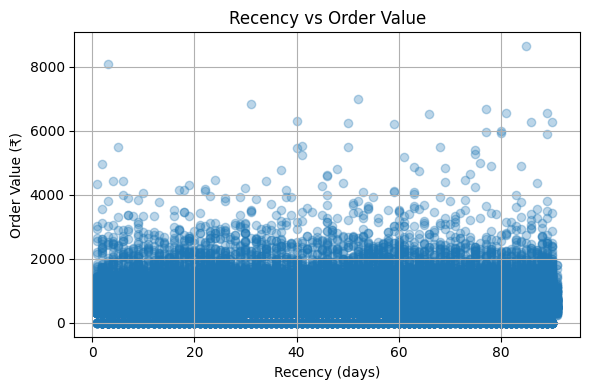

In [30]:
plt.figure(figsize=(6,4))
plt.scatter(rfm['recency'], rfm['order_value'], alpha=0.3)
plt.xlabel('Recency (days)')
plt.ylabel('Order Value (₹)')
plt.title('Recency vs Order Value')
plt.grid(True); plt.tight_layout(); plt.show()
